This is an implementation of the 3 qubit bit flip code in Qiskit. This is meant to be an introduction to Qiskit for those who haven't used it before. 

In [51]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit.circuit.library import MCMT, ZGate

import numpy as np

nqubits_main = 3
nqubits_anc = 2
nqubits_tot = nqubits_main + nqubits_anc

nbits = 2

qreg_q = QuantumRegister(nqubits_tot) # initialize a quantum register of 5 qubits 3 for encoding and two for measurement
creg_q = ClassicalRegister(nbits) # initialize a classical register to store the measurements of the two ancilla qubits

bitflip_circuit = QuantumCircuit(nqubits_tot, nbits)

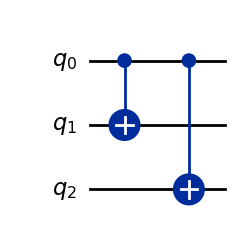

In [52]:
# step 1: encoding
encoding_circuit = QuantumCircuit(nqubits_main) # create a quantum circuit object

encoding_circuit.cx(0, 1)
encoding_circuit.cx(0, 2)

encoding_gate = encoding_circuit.to_gate(label="$U_{enc}$")
bitflip_circuit.append(encoding_gate, [0,1,2])
bitflip_circuit.barrier()

encoding_circuit.draw('mpl')

Next we need to implement a quantum circuit that measures the stabilizers. This corresponds to measuring the $Z_1Z_3$ and $Z_2 Z_3$ stabilizers
which we can do by measuring each individual stabilizer. For the Z operator this corresponds to using a single CNOT. We can then measure the first stabilizer $Z_1Z_3$. For a crude non optimized case, each stabilizer will require one ancilla qubit. Since Qiskit doesn't have the larger controlled multi qubit gates as a type, we will have to define the gate ourselves:

In [54]:
# step 2 - syndrome measurement (Z-axis)
syndrome_meas_circuit = QuantumCircuit(nqubits_tot, nbits)

# apply hadamard gates to ancilla qubits to allow for unitary measurment along the Z-axis
syndrome_meas_circuit.h(3)
syndrome_meas_circuit.h(4)

# measure stabilizers Z1Z3 and Z2Z3
# note that qiskit qubit indexing is reversed, making these stabilizers appear "backwards"
qcz13 = QuantumCircuit(4)
qcz13.pauli('ZIZ', [0,1,2])

qcz23 = QuantumCircuit(3)
qcz23.pauli('ZZI', [0,1,2])

# alternatively, you could reverse the qubit order - but only if you did this during encoding:
# qcz13 = QuantumCircuit(3)
# qcz13.pauli('ZIZ', [2,1,0])

# qcz23 = QuantumCircuit(3)
# qcz23.pauli('IZZ', [2,1,0])

stabilizerZ1Z3 = qcz13.to_gate(label='$U_{ZIZ}$').control(1)
syndrome_meas_circuit.append(stabilizerZ1Z3, [3,0,1,2])

stabilizerZ2Z3 = qcz23.to_gate(label='$U_{ZZI}$').control(1)
syndrome_meas_circuit.append(stabilizerZ2Z3, [4,0,1,2], [1])

syndrome_meas_circuit.measure(3, 0)
syndrome_meas_circuit.measure(4, 1)

print(syndrome_meas_circuit.decompose())
syndrome_meas_circuit.draw('mpl')

CircuitError: 'Index 3 out of range for size 3.'